In [7]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots
import networkx as nx
from tqdm import tqdm
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

In [4]:
# nanonets_utils.store_average_time_currents("scripts/2_funding_period/WP2/step_input/1I_1O/data", 7, 7, 1, 2, 10, 10)

In [49]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

# Nanoparticle Parameter
np_info = {
    "eps_r"         : 2.6,
    "eps_s"         : 3.9,
    "mean_radius"   : 10.0,
    "std_radius"    : 0.0,
    "np_distance"   : 1.0
}

# Nanoparticle Resistances
res_info = {
    "mean_R"    : 25.0,
    "std_R"     : 0.0    
}

# Save Folder
folder  = ""

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter, folder=folder, np_info=np_info, res_info=res_info)

In [6]:
df = pd.read_csv("scripts/2_funding_period/WP2/step_input/1I_1O/data/net_currents_Nx=7_Ny=7_Nz=1_Ne=2.csv")
df

,"(0, 2)","(1, 50)","(2, 0)","(2, 3)","(2, 9)","(3, 2)","(3, 4)","(3, 10)","(4, 3)","(4, 5)",...,"(47, 48)","(48, 41)","(48, 47)","(48, 49)","(49, 42)","(49, 48)","(49, 50)","(50, 1)","(50, 43)","(50, 49)"
0,1300.0,0.0,0.0,300.0,400.0,0.0,600.0,100.0,0.0,400.0,...,0.0,0.0,0.0,300.0,0.0,0.0,400.0,900.0,0.0,0.0
1,1100.0,0.0,0.0,500.0,700.0,0.0,200.0,100.0,0.0,100.0,...,300.0,0.0,0.0,300.0,0.0,0.0,400.0,1500.0,0.0,0.0
2,1100.0,0.0,0.0,400.0,500.0,0.0,200.0,500.0,0.0,200.0,...,400.0,0.0,0.0,300.0,100.0,0.0,300.0,700.0,0.0,0.0
3,900.0,0.0,0.0,200.0,100.0,0.0,600.0,100.0,0.0,200.0,...,300.0,0.0,0.0,100.0,0.0,0.0,400.0,700.0,0.0,0.0
4,800.0,0.0,0.0,200.0,1200.0,0.0,300.0,0.0,0.0,300.0,...,200.0,0.0,0.0,100.0,0.0,0.0,200.0,1600.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,800.0,0.0,0.0,300.0,800.0,0.0,400.0,0.0,0.0,200.0,...,200.0,0.0,0.0,100.0,0.0,0.0,400.0,600.0,0.0,0.0
995,1600.0,0.0,0.0,200.0,700.0,0.0,400.0,200.0,0.0,200.0,...,200.0,0.0,0.0,400.0,0.0,0.0,600.0,1700.0,0.0,0.0
996,800.0,0.0,0.0,300.0,300.0,0.0,600.0,200.0,0.0,100.0,...,600.0,0.0,0.0,0.0,0.0,0.0,600.0,1200.0,0.0,0.0
997,1300.0,0.0,0.0,800.0,400.0,0.0,200.0,300.0,0.0,300.0,...,100.0,0.0,0.0,500.0,0.0,0.0,600.0,800.0,0.0,0.0


In [95]:
junctions   = np.array([eval(val) for val in df.columns])
values      = df.iloc[0,:].values

In [104]:
node_max        = np.max(junctions)
values_new      = []
junctions_new   = []

for n1, junction in enumerate(junctions):

    i       = junction[0]
    j       = junction[1]
    val1    = values[n1]
    
    n2      = np.where(((junctions[:,0]==j) & (junctions[:,1]==i)))[0][0]

    if n2 > n1:
        
        val2  = values[n2]
        values_new.append(np.abs(val2-val1))
        
        if val1 > val2:
            junctions_new.append([i,j])
        else:
            junctions_new.append([j,i])


In [132]:
G = nx.DiGraph()
G.add_nodes_from(np.arange(np.min(junctions), np.max(junctions)+1))
G.add_edges_from(junctions_new)
pos = nx.kamada_kawai_layout(G=G)

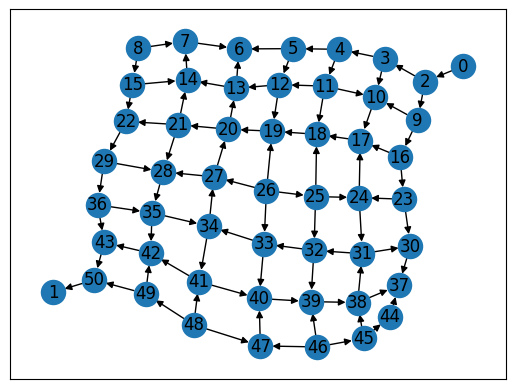

In [135]:
nx.draw_networkx(G=G, pos=pos)

In [ ]:
def display_landscape(path : str, row, Nx, Ny, fig=None, ax=None, cmap='coolwarm', vmin=None, vmax=None,
                        x_label='$x_{NP}$', y_label='$x_{NP}$'):

    arr = pd.read_csv(path).loc[row,:].values
    arr = arr.reshape(Nx, Ny)
    
    if fig == None:
        fig = plt.figure()
    if ax == None:
        ax = fig.add_subplot()
    
    ax.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    return fig, ax